<a href="https://colab.research.google.com/github/hananlu/TugasSLO/blob/main/Naufal_Hanan_L_Tugas10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from imutils import paths
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [26]:
# grab all image paths in the input dataset directory, then initialize
# our list of images and corresponding class labels
print("[INFO] loading images...")
imagePaths = paths.list_images("/content/drive/My Drive/daun")
data = []
labels = []

[INFO] loading images...


In [27]:
# loop over our input images
for imagePath in imagePaths:
	# load the input image from disk, resize it to 64x64 pixels, scale
	# the pixel intensities to the range [0, 1], and then update our
	# images list
	image = Image.open(imagePath)
	image = np.array(image.resize((224, 224))) / 255.0
	data.append(image)

	# extract the class label from the file path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)

In [30]:
print(labels)

['GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02', 'GMB_02',

In [31]:
# encode the labels, converting them from strings to integers
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [32]:
print(labels)

[[1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]


In [33]:
# perform a training and testing split, using 75% of the data for
# training and 25% for evaluation
(trainX, testX, trainY, testY) = train_test_split(np.array(data),	np.array(labels), test_size=0.25)
print(trainX.shape)
print(testX.shape)

(443, 224, 224, 3)
(148, 224, 224, 3)


In [43]:
from keras.applications.mobilenet import MobileNet
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, BatchNormalization

In [44]:
from keras.layers import Dropout
base_model = MobileNet(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)
out = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)
model.summary()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)  

In [45]:
es = EarlyStopping(monitor='val_loss',
                   patience=8,
                   mode='auto',
                   restore_best_weights=True)
checkpoint = ModelCheckpoint('best_weight_scene_mobileNet.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='auto',)

In [46]:
# train the model using the Adam optimizer
print("[INFO] training network...")
opt = Adam(lr=1e-3, decay=1e-3 / 50)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
H = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=50, batch_size=32, callbacks=[es, checkpoint])

[INFO] training network...
Epoch 1/50
14/14 [==============================] - ETA: 0s - loss: 0.9218 - accuracy: 0.6388
Epoch 00001: val_accuracy improved from -inf to 0.33108, saving model to best_weight_scene_mobileNet.h5
14/14 [==============================] - 3s 248ms/step - loss: 0.9218 - accuracy: 0.6388 - val_loss: 5.3791 - val_accuracy: 0.3311
Epoch 2/50
14/14 [==============================] - ETA: 0s - loss: 0.3041 - accuracy: 0.8916
Epoch 00002: val_accuracy improved from 0.33108 to 0.36486, saving model to best_weight_scene_mobileNet.h5
14/14 [==============================] - 3s 213ms/step - loss: 0.3041 - accuracy: 0.8916 - val_loss: 6.2521 - val_accuracy: 0.3649
Epoch 3/50
14/14 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9436
Epoch 00003: val_accuracy did not improve from 0.36486
14/14 [==============================] - 3s 192ms/step - loss: 0.1735 - accuracy: 0.9436 - val_loss: 6.6282 - val_accuracy: 0.3243
Epoch 4/50
14/14 [==============

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


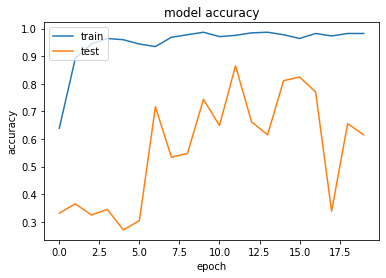

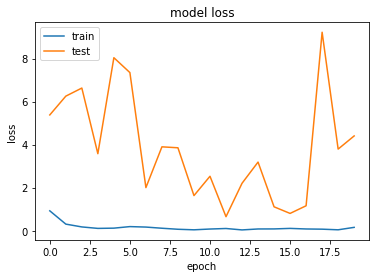

In [47]:
import matplotlib.pyplot as plt

print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

      GMB_02       0.93      0.81      0.87        32
      GMB_04       0.96      0.92      0.94        25
      GMB_05       0.61      1.00      0.76        25
      GMB_07       0.97      0.97      0.97        32
      GMB_10       1.00      0.68      0.81        34

    accuracy                           0.86       148
   macro avg       0.89      0.88      0.87       148
weighted avg       0.90      0.86      0.87       148



In [49]:
model.save('tugas_scene')

INFO:tensorflow:Assets written to: tugas_scene/assets
